* Student Name: Daniel Mwaka
* Student Pace: DSF-FT12-Hybrid
* Instructor Name: Samuel Karu

# Box Office Performance Analysis for New Movie Studio

## Introduction 

The ever-increasing adoption and embracement of internet-hosted, media-sharing platforms exposes audiences to a diverse, highly-dense entertainment alternatives. This claim is justified by the rising number of companies entering the video streaming sector. Additionally, long-video content is increasingly facing stiff competition from social media and video-hosting platforms such as Youtube. Although venturing into the movie production sector is a potentially profitable portfolio diversification strategy; data-driven decision making is vital in orienting the company to conform with market trends and meet target audience expectations.

## Problem Statement

The company plans to diversify its portfolio by launching a new division for movie production. Designing, implementing, sourcing talent, and operational expenses for running a new studio is a costly endevour. To ensure that the produces profitable movies, the company seeks data-driven insights to support appropriate corporate decisions.

## Objectives

<strong> 1: </strong> To determine factors that have a statistically significant relationship to a movie's total grossing. 

<strong> 2: </strong> To determine which movie genres have the highest grossing films

<strong> 3: </strong> To identify key potential competitors based on the cumulative grossing of a studio's movies.

## Data Understanding

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
%matplotlib inline


* Loading and cleaning the bom.movie.movie_gross.csv dataset

In [2]:
# Load the data from the .csv file as a DataFrame and display first five rows
movie_gross_data = pd.read_csv('../zipped-data/bom.movie_gross.csv')
movie_gross_data.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [3]:
# Check the DataFrame's shape
movie_gross_data.shape
print(f"DataFrame consists of {movie_gross_data.shape[0]} rows")
print(f"DataFrame consists of {movie_gross_data.shape[1]} columns")

DataFrame consists of 3387 rows
DataFrame consists of 5 columns


In [4]:
# Check column attributes
movie_gross_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


There are multiple rows entries with missing data values for the `studio`, `domestic_gross`, and `foreign_gross` columns.  

In [5]:
# Create a copy of the data DataFrame to perform data cleaning
gross_data = movie_gross_data.copy()

In [6]:
# Check unique values for the `studio` column
gross_data['studio'].value_counts()

IFC      166
Uni.     147
WB       140
Magn.    136
Fox      136
        ... 
MSF        1
AaF        1
Zee        1
3D         1
App.       1
Name: studio, Length: 257, dtype: int64

In [7]:
# Drop row entries with missing values for the 'studio' column
gross_data = gross_data.dropna(subset=['studio'])

In [8]:
# Check data types of the DataFrame
gross_data.dtypes


title              object
studio             object
domestic_gross    float64
foreign_gross      object
year                int64
dtype: object

In [9]:
# convert the foreign_gross from object to float64

# Remove commas
gross_data['foreign_gross'] = gross_data['foreign_gross'].astype(str).str.replace(',', '') 

# Convert to float datatype
gross_data['foreign_gross'] = pd.to_numeric(gross_data['foreign_gross'], errors='coerce')  

In [10]:
# Confirm the columns are in the appropriate datatype
gross_data.dtypes

title              object
studio             object
domestic_gross    float64
foreign_gross     float64
year                int64
dtype: object

In [11]:
# Check shape 
gross_data.shape
print(f"DataFrame consists of {gross_data.shape[0]} rows")
print(f"DataFrame consists of {gross_data.shape[1]} columns")

DataFrame consists of 3382 rows
DataFrame consists of 5 columns


In [12]:
# Check column attributes
gross_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3382 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3382 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3356 non-null   float64
 3   foreign_gross   2033 non-null   float64
 4   year            3382 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 158.5+ KB


In [13]:
# Compute descriptive statistics for columns with numerical values
gross_data['domestic_gross'].describe()

count    3.356000e+03
mean     2.877149e+07
std      6.700694e+07
min      1.000000e+02
25%      1.200000e+05
50%      1.400000e+06
75%      2.795000e+07
max      9.367000e+08
Name: domestic_gross, dtype: float64

In [14]:
# Compute descriptive statistics for columns with numerical values
gross_data['foreign_gross'].describe()

count    2.033000e+03
mean     7.495490e+07
std      1.375145e+08
min      6.000000e+02
25%      3.700000e+06
50%      1.870000e+07
75%      7.490000e+07
max      9.605000e+08
Name: foreign_gross, dtype: float64

In [15]:
# Imputing the missing values with the respective median for each column is the most appropriate alternative.

# Calculate the medians
domestic_gross_median = gross_data['domestic_gross'].median()
foreign_gross_median = gross_data['foreign_gross'].median()

# Impute missing values with medians
gross_data['domestic_gross'].fillna(domestic_gross_median, inplace=True)
gross_data['foreign_gross'].fillna(foreign_gross_median, inplace=True)

In [16]:
# Check shape after cleaning
gross_data.shape
print(f"DataFrame consists of {gross_data.shape[0]} rows")
print(f"DataFrame consists of {gross_data.shape[1]} columns")

DataFrame consists of 3382 rows
DataFrame consists of 5 columns


* Connecting the im.db dataset, loading and cleaning the `movie_basics` table.

In [17]:
# Create a connection to DataBase
conn = sqlite3.connect('../zipped-data/im.db')

In [18]:
# Load data from the movie_basics table
imdb_basics = pd.read_sql("SELECT * FROM movie_basics", conn)
imdb_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [19]:
imdb_basics.shape
print(f"DataFrame consists of {imdb_basics.shape[0]} rows")
print(f"DataFrame consists of {imdb_basics.shape[1]} columns")

DataFrame consists of 146144 rows
DataFrame consists of 6 columns


In [20]:
imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [21]:
# Create a copy of the data DataFrame to perform data cleaning
imdb_basics_cleaned = imdb_basics.copy()

Dropping the `original_title` since they are redundant to the `primary_title` and for entries they are not; they are the translated version of movie titles from English to other languages. 

In [22]:
imdb_basics_cleaned = imdb_basics_cleaned.drop(columns=['original_title']) 

In [23]:
# Drop row entries with missing values for the primary_title, genres, and runtime_minutes columns
imdb_basics_cleaned = imdb_basics_cleaned.dropna(subset=['primary_title'])
imdb_basics_cleaned = imdb_basics_cleaned.dropna(subset=['genres'])
imdb_basics_cleaned = imdb_basics_cleaned.dropna(subset=['runtime_minutes'])

In [24]:
# Compute descriptive statistics for the runtime_minutes column
imdb_basics_cleaned.describe()

,start_year,runtime_minutes
count,112233.000000,112233.000000
mean,2014.402101,86.261902
std,2.639042,167.895938
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2014.000000,87.000000
75%,2017.000000,99.000000
max,2022.000000,51420.000000


Movies typically never exceed three hours. So the 51420 runtime_minute entry alludes the possiblity of outliers in the dataset.

In [25]:
# Drop all entries with a runtime exceeding three hours by 20 minutes or more
imdb_basics_cleaned = imdb_basics_cleaned[imdb_basics_cleaned['runtime_minutes'] <= 200]

In [26]:
# Check shape after cleaning
imdb_basics_cleaned.shape
print(f"DataFrame consists of {imdb_basics_cleaned.shape[0]} rows")
print(f"DataFrame consists of {imdb_basics_cleaned.shape[1]} columns")

DataFrame consists of 111867 rows
DataFrame consists of 5 columns


* Loading and cleaning the movie_ratings table

In [27]:
# Load data from the movie_ratings table
imdb_ratings = pd.read_sql("SELECT * FROM movie_ratings", conn)
imdb_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [28]:
imdb_ratings.shape
print(f"DataFrame consists of {imdb_ratings.shape[0]} rows")
print(f"DataFrame consists of {imdb_ratings.shape[1]} columns")

DataFrame consists of 73856 rows
DataFrame consists of 3 columns


In [29]:
# Check column attributes
imdb_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [30]:
# print the count of missing values 
imdb_ratings.isna().sum()

movie_id         0
averagerating    0
numvotes         0
dtype: int64

In [31]:
# checking for duplicates
imdb_ratings.duplicated().sum()

0

The imdb_ratings Dataframe neither has missing values nor duplicates and does not require data cleaning.

### Merging the three DataFrames

Perform an inner join on the imdb_basics_cleaned and the imdb_ratings DataFrames. An inner join returns only the rows with matching keys (movie_id) in both DataFrames. The left join is inappropriate since it would lead to NaNs for row entries of the right DataFrame (imdb_ratings) that don't have a matching movie_id key. 

In [32]:
# Inner Join
imdb_dataset = pd.merge(imdb_basics_cleaned, imdb_ratings, on='movie_id', how='inner')
print("Inner Join:")
imdb_dataset.head()

Inner Join:


,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
4,tt0137204,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263


In [33]:
imdb_dataset.shape

(65563, 7)

Modify the name of the `primary_title` column name to `title` to become a matching key in both the imdb_dataset and gross_data DataFrames. Creating a matching key allows for the merging of the DataFrames via an inner join. 

In [34]:
# Modifying the name of the column name primary_title to title
imdb_dataset = imdb_dataset.rename(columns={'primary_title': 'title'})

In [35]:
# Check columns
imdb_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65563 entries, 0 to 65562
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         65563 non-null  object 
 1   title            65563 non-null  object 
 2   start_year       65563 non-null  int64  
 3   runtime_minutes  65563 non-null  float64
 4   genres           65563 non-null  object 
 5   averagerating    65563 non-null  float64
 6   numvotes         65563 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 4.0+ MB


In [36]:
# Using an inner join to merge 
df = pd.merge(imdb_dataset, gross_data, on='title', how='inner')
print("Inner Join:")
df.head(10)

Inner Join:


,movie_id,title,start_year,runtime_minutes,genres,averagerating,numvotes,studio,domestic_gross,foreign_gross,year
0,tt0315642,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378,Relbig.,1100000.0,18700000.0,2016
1,tt0337692,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,IFC,744000.0,8000000.0,2012
2,tt4339118,On the Road,2014,89.0,Drama,6.0,6,IFC,744000.0,8000000.0,2012
3,tt5647250,On the Road,2016,121.0,Drama,5.7,127,IFC,744000.0,8000000.0,2012
4,tt0359950,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,Fox,58200000.0,129900000.0,2013
5,tt0365907,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,Uni.,26300000.0,26900000.0,2014
6,tt0369610,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,Uni.,652300000.0,1019.4,2015
7,tt0372538,Spy,2011,110.0,"Action,Crime,Drama",6.6,78,Fox,110800000.0,124800000.0,2015
8,tt3079380,Spy,2015,119.0,"Action,Comedy,Crime",7.0,213908,Fox,110800000.0,124800000.0,2015
9,tt0376136,The Rum Diary,2011,119.0,"Comedy,Drama",6.2,94787,FD,13100000.0,10800000.0,2011


In [37]:
# Create a copy of the df DataFrame and check shape
df_clean = df.copy()
df_clean.shape

(2971, 11)

Define a function to check and drop duplicate entries based on a movie's `title`, `studio`, `domestic_gross`, `foreign_gross`, and `year`

In [38]:
def drop_duplicate_entries(df):
    """
    Define function to drop duplicate entries based on:
    - Marching title
    - Produced by studio
    - Same domestic_gross
    - Same foreign_gross
    - Produced same year
    """
    columns_to_check = ['title', 'studio', 'domestic_gross', 'foreign_gross', 'year']
    duplicate_removed = df.drop_duplicates(subset=columns_to_check, keep='first')
    return duplicate_removed

# Call the drop_duplicate function and pass in df_clean as the argument
df_clean = drop_duplicate_entries(df_clean)
df_clean.head(20)

,movie_id,title,start_year,runtime_minutes,genres,averagerating,numvotes,studio,domestic_gross,foreign_gross,year
0,tt0315642,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378,Relbig.,1100000.0,18700000.0,2016
1,tt0337692,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,IFC,744000.0,8000000.0,2012
4,tt0359950,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,Fox,58200000.0,129900000.0,2013
5,tt0365907,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,Uni.,26300000.0,26900000.0,2014
6,tt0369610,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,Uni.,652300000.0,1019.4,2015
7,tt0372538,Spy,2011,110.0,"Action,Crime,Drama",6.6,78,Fox,110800000.0,124800000.0,2015
9,tt0376136,The Rum Diary,2011,119.0,"Comedy,Drama",6.2,94787,FD,13100000.0,10800000.0,2011
10,tt0376479,American Pastoral,2016,108.0,"Crime,Drama",6.1,12898,LGF,544000.0,18700000.0,2016
11,tt0383010,The Three Stooges,2012,92.0,"Comedy,Family",5.1,28570,Fox,44300000.0,10500000.0,2012
12,tt0398286,Tangled,2010,100.0,"Adventure,Animation,Comedy",7.8,366366,BV,200800000.0,391000000.0,2010


In [39]:
# Create a new column for total_grossing
df_clean['total_grossing'] = df_clean['domestic_gross'] + df_clean['foreign_gross']

In [40]:
# # Function to extract the first genre from the string

# def extract_first_genre(genre_str):
#     if isinstance(genre_str, str):  # Check if it's a string
#         return genre_str.split(',')[0].strip()
#     else:
#         return np.nan  # Or some other appropriate missing value representation

# df_clean['genres'] = df_clean['genres'].apply(extract_first_genre)

In [41]:
# Function to randomly select a genre from the string value for example (Action, Crime, Drama)
# Randomly selecting one genre from the string mitigates selection bias 

def extract_random_genre(genre_str):
    if isinstance(genre_str, str):  # Check if it's a string
        genres = [genre.strip() for genre in genre_str.split(',')]
        if genres:
            return random.choice(genres)
        else:
            return np.nan  # Return NaN if the list of genres is empty
    else:
        return np.nan  # Or some other appropriate missing value representation

df_clean['genres'] = df_clean['genres'].apply(extract_random_genre)

In [47]:
df_clean.head(20)

,movie_id,title,start_year,runtime_minutes,genres,averagerating,numvotes,studio,domestic_gross,foreign_gross,year,total_grossing
0,tt0315642,Wazir,2016,103.0,Crime,7.1,15378,Relbig.,1100000.0,18700000.0,2016,19800000.0
1,tt0337692,On the Road,2012,124.0,Drama,6.1,37886,IFC,744000.0,8000000.0,2012,8744000.0
4,tt0359950,The Secret Life of Walter Mitty,2013,114.0,Adventure,7.3,275300,Fox,58200000.0,129900000.0,2013,188100000.0
5,tt0365907,A Walk Among the Tombstones,2014,114.0,Crime,6.5,105116,Uni.,26300000.0,26900000.0,2014,53200000.0
6,tt0369610,Jurassic World,2015,124.0,Action,7.0,539338,Uni.,652300000.0,1019.4,2015,652301019.4
7,tt0372538,Spy,2011,110.0,Drama,6.6,78,Fox,110800000.0,124800000.0,2015,235600000.0
9,tt0376136,The Rum Diary,2011,119.0,Comedy,6.2,94787,FD,13100000.0,10800000.0,2011,23900000.0
10,tt0376479,American Pastoral,2016,108.0,Crime,6.1,12898,LGF,544000.0,18700000.0,2016,19244000.0
11,tt0383010,The Three Stooges,2012,92.0,Family,5.1,28570,Fox,44300000.0,10500000.0,2012,54800000.0
12,tt0398286,Tangled,2010,100.0,Adventure,7.8,366366,BV,200800000.0,391000000.0,2010,591800000.0


# Data Analysis

### z-test

Conduct a z-test to compare the averages of `domestic_gross` to `foreign_gross` to determine whether or not the differences could have happened by chance.

In [43]:
# Assign variables for the z-test
domestic_gross = df['domestic_gross']
foreign_gross = df['foreign_gross']

# Calculate the means
mean_domestic = np.mean(domestic_gross)
mean_foreign = np.mean(foreign_gross)

# Calculate the standard deviations
std_domestic = np.std(domestic_gross, ddof=1)  # ddof=1 for sample standard deviation
std_foreign = np.std(foreign_gross, ddof=1)

# Calculate the sample sizes
n_domestic = len(domestic_gross)
n_foreign = len(foreign_gross)

# Compute 
t_statistic, p_value = stats.ttest_ind(domestic_gross, foreign_gross, equal_var=False)
t_statistic, p_value

(-10.15070046888189, 5.707635743081175e-24)

* Since the p-value (5.7 e-24) is less than alpha; the difference between the domestic grossing and foreign grossing is statistically significant and could not have happened by chance. 

### ANOVA

ANOVA is deemed the appropriate statistical test for evaluating several variables whether they are potential predictor factors/ have a significant influence on the dependent variable. In this case; the target variable is the total grossing of a film. The predictor factors to be examined include: `genre`, `runtime_minutes`, and `averagerating`. Since people have unique movie genre preferences; this variable is a potential predictor factor for the total grossing of a film. Genre preference is also influenced by pop culture. For instance, the peak period of the <strong> Breaking Bad </strong> series franchise in the early 2010s triggered a spike in the viewership for Crime genre films. However, the validity of a potential statistically significant relationship between genre and movie grossing must be substantiated with empirical evidence to support data-driven corporate decisions. 

A movie's runtime is also a potential predictor factor on a film's total grossing. For instance, excessively long movies can easily become boring to viewers and film critics especially during the premiere week. Negative perceptions from the audience and criticisms voiced by film critics across platforms such as RottenTomato.com can have a substantial impact on a movie's total grossing in the long-run. Consequently, films with a relatively higher average rating are likelier to outperform their counterparts in the demand for theater tickets and viewership numbers across streaming platforms such as Netflix. Thus, the validity of a statistically significant influence of `runtime_minutes` and `averagerating` on `total_grossing` must be substantiated quantitatively.      

* <Strong> Null Hypothesis: </Strong> A movie's genre, runtime minutes, and average rating don't have an impact on total grossing.

* <Strong> Alternative Hypothesis: </Strong> A movie's genre, runtime, and average rating have a significant influence on total grossing. 

* <strong> Significance level (alpha) = </strong> 0.05

In [44]:
# Perform  ANOVA test 
formula = 'total_grossing ~ C(genres) + runtime_minutes + averagerating'
model = ols(formula, data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(genres),1.373224e+19,20.0,29.479427,4.149035e-100
runtime_minutes,1.839741e+18,1.0,78.988588,1.148969e-18
averagerating,1.624911e+18,1.0,69.764961,1.077529e-16
Residual,5.990503e+19,2572.0,NaN,NaN


Reject the Null Hypothesis because the p-values for `genre`, `runtime_minutes`, and `averagerating` are less than alpha (0.05). Thus, a movie's genre, runtime, and average rating have a statistically significant influence on total grossing.  

### Visualizations

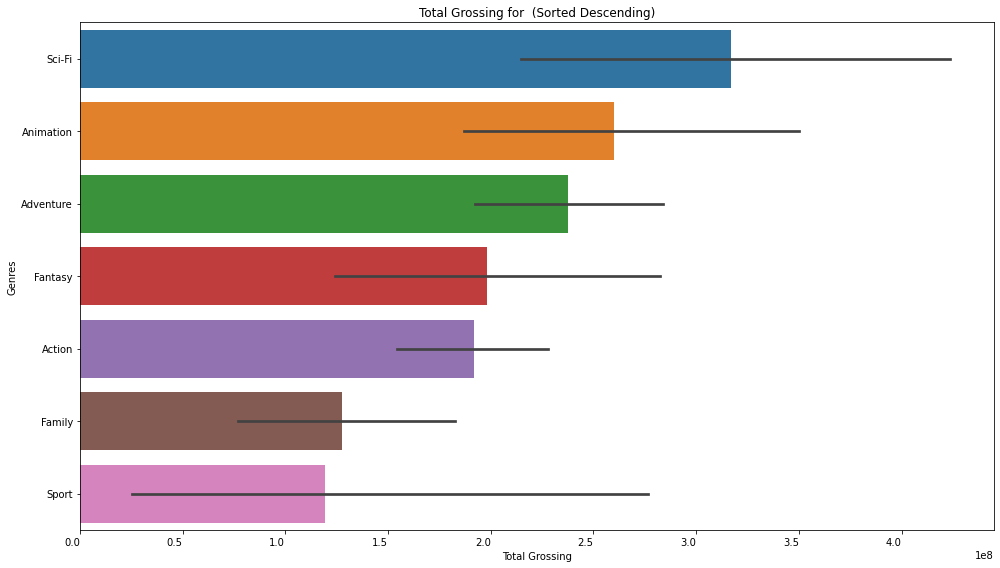

In [45]:
# Visualize total grossing distribution for different movie genres

# Calculate the mean total_grossing for each genre
genre_gross = df_clean.groupby('genres')['total_grossing'].mean().sort_values(ascending=False).head(7)

# Get the sorted order of genres
sorted_genres = genre_gross.index

plt.figure(figsize=(14, 8))
sns.barplot(x='total_grossing', y='genres', data=df_clean, order=sorted_genres)
plt.title('Total Grossing for  (Sorted Descending)')
plt.xlabel('Total Grossing')
plt.ylabel('Genres')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

* Studios the company can do a case study on or benchmark to see what works

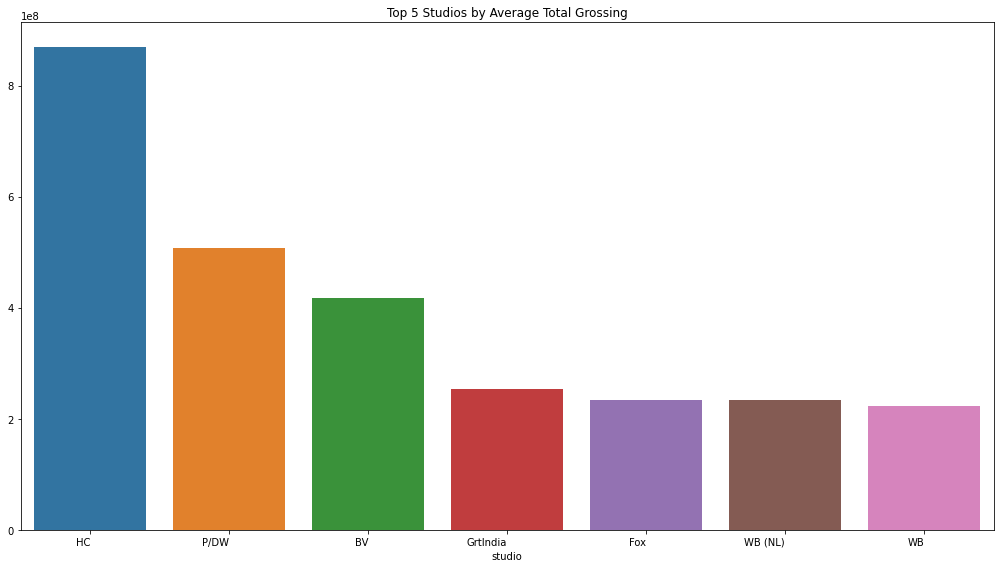

In [46]:
# use .groupby() to group studio and total_grossing
studio_gross_mean = df_clean.groupby('studio')['total_grossing'].mean().sort_values(ascending=False).head(7)

plt.figure(figsize=(14, 8))
sns.barplot(x=studio_gross_mean.index, y=studio_gross_mean.values)
plt.title('Top 5 Studios by Average Total Grossing')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()